In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction

In [2]:
data = pd.read_csv('Dataset/emergency_classification.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2352 entries, 0 to 2351
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   image_names       2352 non-null   object
 1   emergency_or_not  2352 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 36.9+ KB


In [4]:
data.head()

,image_names,emergency_or_not
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [5]:
data['emergency_or_not'].value_counts()

0    1361
1     991
Name: emergency_or_not, dtype: int64

In [6]:
X = []
for image_name in data['image_names']:
    img = plt.imread('Dataset/images/'+image_name)
    X.append(img)
X = np.array(X)

In [7]:
X.shape

(2352, 224, 224, 3)

In [8]:
y = data['emergency_or_not']

In [9]:
y.shape

(2352,)

In [10]:
rng = np.random.default_rng()

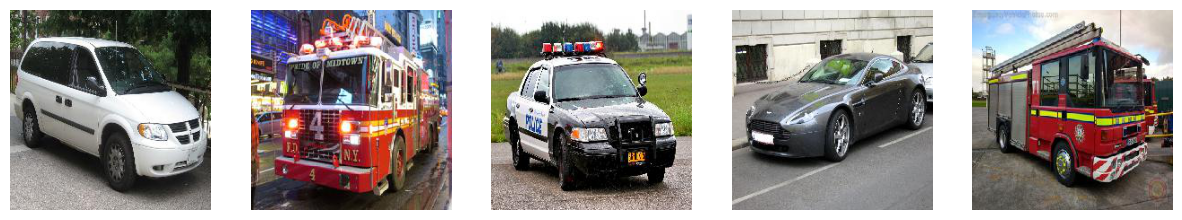

In [11]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(15,20))
for i in range(5):
    ax[i].imshow(X[rng.integers(X.shape[0])])
    ax[i].axis('off')

# Processing

In [12]:
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, det_curve
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay

In [13]:
X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])

In [14]:
X.shape

(2352, 150528)

In [15]:
X.min(), X.max()

(0, 255)

In [16]:
X = X / X.max()

In [17]:
X.min(), X.max()

(0.0, 1.0)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [67]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1646, 150528), (706, 150528), (1646,), (706,))

# Basic Model

In [21]:
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score

In [80]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [79]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [116]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.batchnorm = nn.BatchNorm1d(100)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.batchnorm(x)
        x = self.dropout(x)        
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [130]:
model = Net()

In [131]:
model

Net(
  (fc1): Linear(in_features=150528, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (batchnorm): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [132]:
for name,param in model.named_parameters():
    print(name, param.size())

fc1.weight torch.Size([100, 150528])
fc1.bias torch.Size([100])
fc2.weight torch.Size([100, 100])
fc2.bias torch.Size([100])
fc3.weight torch.Size([1, 100])
fc3.bias torch.Size([1])
batchnorm.weight torch.Size([100])
batchnorm.bias torch.Size([100])


In [133]:
optimizer = Adam(model.parameters())

In [134]:
criterion = nn.BCELoss()

In [142]:
epochs = 10
batch_size = 128
for epoch in range(epochs):
    training_loss = []
    training_accuracy = []
    for i in range(0, X_train.shape[0], batch_size):
        
        inputs, labels = X_train[i:i+batch_size], y_train[i:i+batch_size]
        labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        training_loss.append(loss.item())
        
        accuracy = accuracy_score(labels, (outputs >= 0.5).int())
        training_accuracy.append(accuracy)
        
        loss.backward()
        optimizer.step()
    print(f'epoch: {epoch} \t training loss: {np.mean(training_loss):.3f}' 
          f'\t training_accuracy: {np.mean(training_accuracy):.3f}')   


epoch: 0 	 training loss: 0.653	 training_accuracy: 0.612
epoch: 1 	 training loss: 0.635	 training_accuracy: 0.647
epoch: 2 	 training loss: 0.618	 training_accuracy: 0.682
epoch: 3 	 training loss: 0.598	 training_accuracy: 0.707
epoch: 4 	 training loss: 0.579	 training_accuracy: 0.716
epoch: 5 	 training loss: 0.564	 training_accuracy: 0.725
epoch: 6 	 training loss: 0.549	 training_accuracy: 0.731
epoch: 7 	 training loss: 0.534	 training_accuracy: 0.739
epoch: 8 	 training loss: 0.514	 training_accuracy: 0.768
epoch: 9 	 training loss: 0.493	 training_accuracy: 0.784


In [143]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    test_loss = criterion(outputs, y_test.unsqueeze(1))
    test_accuracy = accuracy_score(y_test, (outputs >= 0.5).int())

In [144]:
test_loss.item(), test_accuracy

(0.5586754679679871, 0.7025495750708215)

In [161]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import efficientnet, inception_v3
from tensorflow.keras.utils import to_categorical

In [187]:
model = Sequential()
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal(), input_shape=(X.shape[1],)))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu', kernel_initializer=HeNormal()))
model.add(Dropout(rate=0.2))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

In [188]:
# summary of the model
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 25)                3763225   
                                                                 
 dropout_25 (Dropout)        (None, 25)                0         
                                                                 
 batch_normalization_25 (Bat  (None, 25)               100       
 chNormalization)                                                
                                                                 
 dense_47 (Dense)            (None, 25)                650       
                                                                 
 dropout_26 (Dropout)        (None, 25)                0         
                                                                 
 batch_normalization_26 (Bat  (None, 25)               100       
 chNormalization)                                    

In [167]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [168]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=30, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=10),
             ModelCheckpoint(filepath='vehicle_model.h5', monitor='val_binary_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [169]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, 
                    validation_data=(X_test, y_test))

Epoch 1/50
13/13 [==============================] - 8s 484ms/step - loss: 0.7752 - binary_accuracy: 0.5419 - val_loss: 2.2128 - val_binary_accuracy: 0.5609
Epoch 2/50
13/13 [==============================] - 2s 140ms/step - loss: 0.7536 - binary_accuracy: 0.5656 - val_loss: 1.1953 - val_binary_accuracy: 0.5708
Epoch 3/50
13/13 [==============================] - 2s 126ms/step - loss: 0.7044 - binary_accuracy: 0.5960 - val_loss: 0.8050 - val_binary_accuracy: 0.6416
Epoch 4/50
13/13 [==============================] - 2s 127ms/step - loss: 0.6688 - binary_accuracy: 0.6185 - val_loss: 0.7686 - val_binary_accuracy: 0.6487
Epoch 5/50
13/13 [==============================] - 2s 137ms/step - loss: 0.6922 - binary_accuracy: 0.5960 - val_loss: 0.6759 - val_binary_accuracy: 0.6671
Epoch 6/50
13/13 [==============================] - 2s 150ms/step - loss: 0.6547 - binary_accuracy: 0.6434 - val_loss: 0.6286 - val_binary_accuracy: 0.6912
Epoch 7/50
13/13 [==============================] - 2s 138ms/ste

In [173]:
model = load_model('vehicle_model.h5')

In [174]:
prediction = model.predict(X_test)

23/23 [==============================] - 0s 12ms/step


In [175]:
prediction_cat = (prediction >= 0.5).astype(int)

In [176]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       396
           1       0.72      0.71      0.72       310

    accuracy                           0.75       706
   macro avg       0.75      0.75      0.75       706
weighted avg       0.75      0.75      0.75       706



In [177]:
history_df = pd.DataFrame(history.history)

In [178]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.775191,0.541920,2.212826,0.560907
1,0.753589,0.565614,1.195254,0.570822
2,0.704392,0.595990,0.805021,0.641643
3,0.668763,0.618469,0.768616,0.648725
4,0.692231,0.595990,0.675861,0.667139


Text(0.5, 0.01, 'epochs')

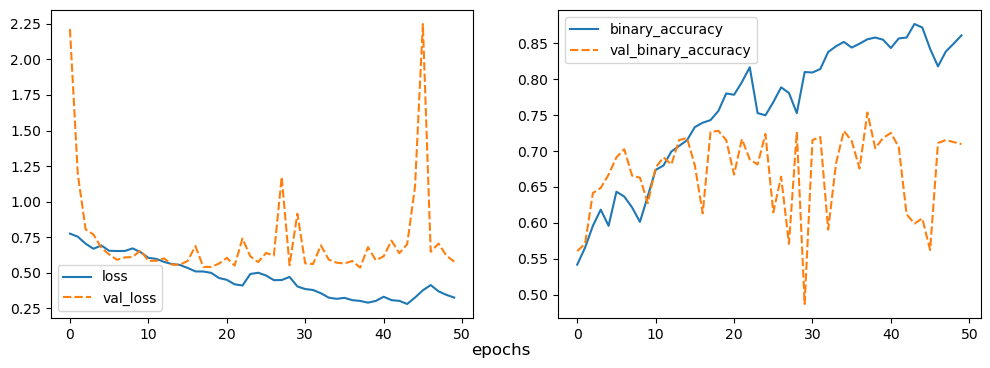

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

actual class 0, predicted probability 0.4026157259941101


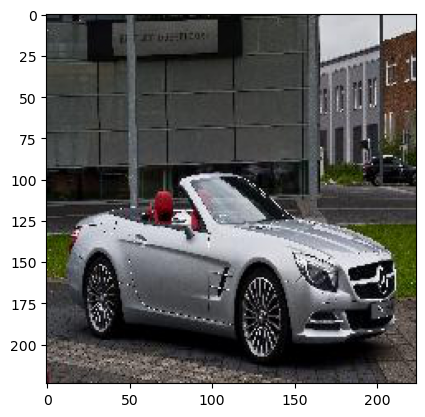

In [180]:
index = rng.integers(X_test.shape[0])
plt.imshow(np.reshape(X_test[index], (224,224,3)))
print(f'actual class {y_test.iloc[index]}, predicted probability {prediction[index][0]}')

# CNN

In [13]:
X.shape

(2352, 224, 224, 3)

In [14]:
X = np.moveaxis(X, -1, 1)

In [15]:
X.shape

(2352, 3, 224, 224)

In [16]:
X = X / X.max()

In [17]:
X.min(), X.max()

(0.0, 1.0)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [19]:
X_train.shape, X_test.shape

((1646, 3, 224, 224), (706, 3, 224, 224))

In [22]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

In [23]:
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv2d1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3)
        self.conv2d2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*54*54, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.conv2d1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.conv2d2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [25]:
model = CNN()

In [26]:
model

CNN(
  (conv2d1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2d2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=373248, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [27]:
for name,param in model.named_parameters():
    print(name, param.size())

conv2d1.weight torch.Size([64, 3, 3, 3])
conv2d1.bias torch.Size([64])
conv2d2.weight torch.Size([128, 64, 3, 3])
conv2d2.bias torch.Size([128])
fc1.weight torch.Size([64, 373248])
fc1.bias torch.Size([64])
fc2.weight torch.Size([1, 64])
fc2.bias torch.Size([1])


In [28]:
optimizer = Adam(model.parameters())

In [29]:
criterion = nn.BCELoss()

In [30]:
epochs = 10
batch_size = 64
for epoch in range(epochs):
    training_loss = []
    training_accuracy = []
    for i in range(0, X_train.shape[0], batch_size):
        
        inputs, labels = X_train[i:i+batch_size], y_train[i:i+batch_size]
        labels = labels.unsqueeze(1)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        training_loss.append(loss.item())
        
        accuracy = accuracy_score(labels, (outputs >= 0.5).int())
        training_accuracy.append(accuracy)
        
        loss.backward()
        optimizer.step()
    print(f'epoch: {epoch} \t training loss: {np.mean(training_loss):.3f}' 
          f'\t training_accuracy: {np.mean(training_accuracy):.3f}')   


epoch: 0 	 training loss: 1.071	 training_accuracy: 0.551
epoch: 1 	 training loss: 0.576	 training_accuracy: 0.681
epoch: 2 	 training loss: 0.496	 training_accuracy: 0.763
epoch: 3 	 training loss: 0.430	 training_accuracy: 0.803
epoch: 4 	 training loss: 0.407	 training_accuracy: 0.820


KeyboardInterrupt: 

In [31]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    test_loss = criterion(outputs, y_test.unsqueeze(1))
    test_accuracy = accuracy_score(y_test, (outputs >= 0.5).int())

In [32]:
test_loss.item(), test_accuracy

(0.43508514761924744, 0.7988668555240793)

In [19]:
model = Sequential()
model.add(Conv2D(filters=25, kernel_size=(5,5), dilation_rate=(1,1), strides=(2,2), padding='valid', input_shape=X.shape[1:]))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(4,4), padding='valid'))

model.add(Conv2D(filters=25, kernel_size=(5,5), dilation_rate=(1,1), strides=(2,2), padding='valid'))
model.add(LeakyReLU())
model.add(MaxPool2D(pool_size=(4,4), padding='valid'))

model.add(Flatten())
model.add(Dense(units=25, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(BatchNormalization())
model.add(Dense(units=25, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(BatchNormalization())
model.add(Dense(units=1, activation='sigmoid'))

2023-01-20 17:37:36.260944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 25)      1900      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 110, 110, 25)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 25)        15650     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 25)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 25)         0         
 2D)                                                    

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(), 
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [22]:
callbacks = [EarlyStopping(monitor='val_binary_accuracy', min_delta=.001, patience=20, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=5),
             ModelCheckpoint(filepath='vehicle_model_cnn.h5', monitor='val_binary_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [23]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, callbacks=callbacks, 
                    validation_data=(X_test, y_test))

Epoch 1/50


2023-01-20 17:40:38.488850: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 991076352 exceeds 10% of free system memory.
2023-01-20 17:40:40.191193: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2023-01-20 17:40:40.191507: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2023-01-20 17:40:40.191577: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.
2023-01-20 17:40:40.191634: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 77070336 exceeds 10% of free system memory.


13/13 [==============================] - 7s 483ms/step - loss: 0.7993 - binary_accuracy: 0.5340 - val_loss: 0.6760 - val_binary_accuracy: 0.5609
Epoch 2/50
13/13 [==============================] - 5s 414ms/step - loss: 0.7555 - binary_accuracy: 0.5419 - val_loss: 0.6688 - val_binary_accuracy: 0.5609
Epoch 3/50
13/13 [==============================] - 6s 429ms/step - loss: 0.7127 - binary_accuracy: 0.5753 - val_loss: 0.6647 - val_binary_accuracy: 0.5609
Epoch 4/50
13/13 [==============================] - 5s 425ms/step - loss: 0.6967 - binary_accuracy: 0.5680 - val_loss: 0.6738 - val_binary_accuracy: 0.5609
Epoch 5/50
13/13 [==============================] - 5s 426ms/step - loss: 0.6890 - binary_accuracy: 0.5966 - val_loss: 0.6511 - val_binary_accuracy: 0.5850
Epoch 6/50
13/13 [==============================] - 5s 421ms/step - loss: 0.6401 - binary_accuracy: 0.6324 - val_loss: 0.6550 - val_binary_accuracy: 0.5637
Epoch 7/50
13/13 [==============================] - 5s 425ms/step - loss: 0

In [27]:
model = load_model('vehicle_model_cnn.h5')

In [28]:
prediction = model.predict(X_test)

23/23 [==============================] - 1s 22ms/step


In [29]:
prediction_cat = (prediction >= 0.5).astype(int)

In [30]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91       396
           1       0.91      0.83      0.87       310

    accuracy                           0.89       706
   macro avg       0.89      0.88      0.89       706
weighted avg       0.89      0.89      0.89       706



In [31]:
history_df = pd.DataFrame(history.history)

In [32]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.799266,0.534022,0.676021,0.560907
1,0.755483,0.541920,0.668797,0.560907
2,0.712747,0.575334,0.664677,0.560907
3,0.696714,0.568044,0.673761,0.560907
4,0.688961,0.596598,0.651117,0.584986


Text(0.5, 0.01, 'epochs')

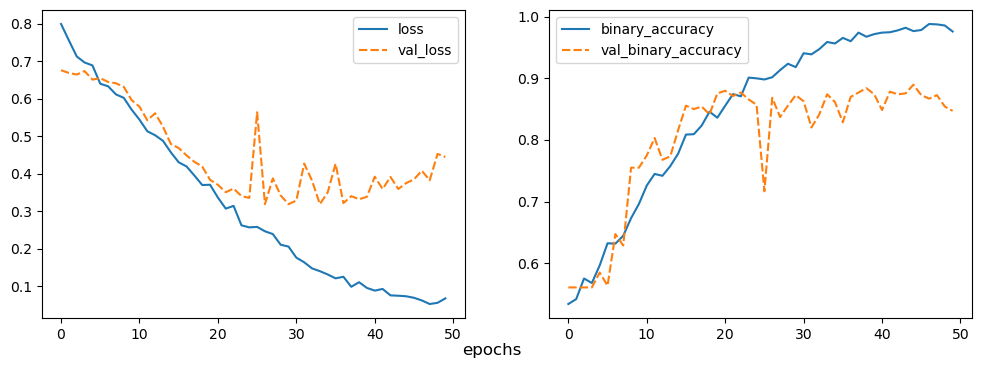

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

actual class 1, predicted probability 0.973733127117157


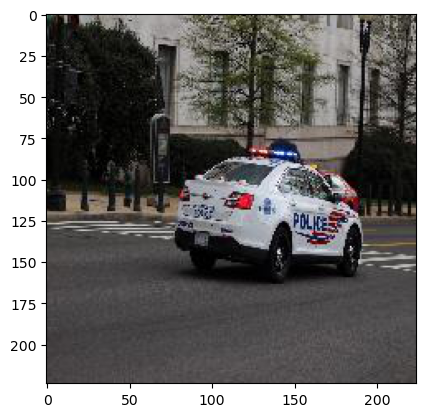

In [34]:
index = rng.integers(X_test.shape[0])
plt.imshow(np.reshape(X_test[index], (224,224,3)))
print(f'actual class {y_test.iloc[index]}, predicted probability {prediction[index][0]}')

# Transfer Learning

In [35]:
import torchvision.models

In [40]:
all_models = torchvision.models.list_models

In [49]:
for i in all_models():
    print(i)

alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
deeplabv3_mobilenet_v3_large
deeplabv3_resnet101
deeplabv3_resnet50
densenet121
densenet161
densenet169
densenet201
efficientnet_b0
efficientnet_b1
efficientnet_b2
efficientnet_b3
efficientnet_b4
efficientnet_b5
efficientnet_b6
efficientnet_b7
efficientnet_v2_l
efficientnet_v2_m
efficientnet_v2_s
fasterrcnn_mobilenet_v3_large_320_fpn
fasterrcnn_mobilenet_v3_large_fpn
fasterrcnn_resnet50_fpn
fasterrcnn_resnet50_fpn_v2
fcn_resnet101
fcn_resnet50
fcos_resnet50_fpn
googlenet
inception_v3
keypointrcnn_resnet50_fpn
lraspp_mobilenet_v3_large
maskrcnn_resnet50_fpn
maskrcnn_resnet50_fpn_v2
maxvit_t
mc3_18
mnasnet0_5
mnasnet0_75
mnasnet1_0
mnasnet1_3
mobilenet_v2
mobilenet_v3_large
mobilenet_v3_small
mvit_v1_b
mvit_v2_s
quantized_googlenet
quantized_inception_v3
quantized_mobilenet_v2
quantized_mobilenet_v3_large
quantized_resnet18
quantized_resnet50
quantized_resnext101_32x8d
quantized_resnext101_64x4d
quantized_shufflenet_v2_x0_

In [187]:
X.shape

(2352, 224, 224, 3)

In [188]:
y = to_categorical(y)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [192]:
X_train = inception_v3.preprocess_input(X_train)

In [193]:
X_test = inception_v3.preprocess_input(X_test)

In [227]:
X_train.shape, X_test.shape

((1646, 224, 224, 3), (706, 224, 224, 3))

In [228]:
y_train.shape, y_test.shape

((1646, 2), (706, 2))

In [246]:
base_model = efficientnet.EfficientNetB0(include_top=True, weights='imagenet')

In [234]:
base_model = inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=Input(shape=(224,224,3)))

In [163]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_34 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_34[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [247]:
len(base_model.layers)

241

In [248]:
base_model.layers[-10:]

In [237]:
for layer in base_model.layers:
    layer.trainable = False

In [253]:
dense = Dense(25, activation='relu')(base_model.layers[-2].output)
y = Dense(2, activation='softmax')(dense)

In [249]:
y = Dense(2, activation='softmax')(base_model.layers[-2].output)

In [254]:
model = Model(inputs=base_model.input, outputs=y)

In [255]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [241]:
callbacks = [EarlyStopping(monitor='val_categorical_accuracy', min_delta=.001, patience=10, verbose=1, 
                           mode='max', baseline=0.5, restore_best_weights=True, start_from_epoch=5),
             ModelCheckpoint(filepath='vehicle_model_tl.h5', monitor='val_categorical_accuracy', verbose=0,
                             mode='max', save_best_only=True)]

In [242]:
history = model.fit(X_train, y_train, batch_size=128, epochs=12, callbacks=callbacks, 
                    validation_data=(X_test, y_test))

Epoch 1/12
13/13 [==============================] - 135s 10s/step - loss: 0.3510 - categorical_accuracy: 0.8384 - val_loss: 0.2151 - val_categorical_accuracy: 0.9235
Epoch 2/12
13/13 [==============================] - 135s 11s/step - loss: 0.1865 - categorical_accuracy: 0.9271 - val_loss: 0.1794 - val_categorical_accuracy: 0.9292
Epoch 3/12
13/13 [==============================] - 135s 11s/step - loss: 0.1532 - categorical_accuracy: 0.9447 - val_loss: 0.1680 - val_categorical_accuracy: 0.9334
Epoch 4/12
13/13 [==============================] - 124s 10s/step - loss: 0.1512 - categorical_accuracy: 0.9441 - val_loss: 0.1622 - val_categorical_accuracy: 0.9363
Epoch 5/12
13/13 [==============================] - 125s 10s/step - loss: 0.1266 - categorical_accuracy: 0.9550 - val_loss: 0.1463 - val_categorical_accuracy: 0.9462
Epoch 6/12
13/13 [==============================] - 119s 9s/step - loss: 0.1110 - categorical_accuracy: 0.9642 - val_loss: 0.1392 - val_categorical_accuracy: 0.9419
Epoch

KeyboardInterrupt: 

In [256]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, 
                    validation_data=(X_test, y_test))

Epoch 1/6
 7/13 [===============>..............] - ETA: 12:31 - loss: 0.2880 - categorical_accuracy: 0.8739

KeyboardInterrupt: 

In [150]:
model = load_model('vehicle_model_tl.h5')

ValueError: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x0000025811DA5190>.

In [243]:
prediction = model.predict(X_test)

23/23 [==============================] - 41s 2s/step


In [244]:
prediction_cat = (prediction >= 0.5).astype(int)

In [245]:
print(classification_report(y_test, prediction_cat))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95       396
           1       0.92      0.95      0.94       310

   micro avg       0.94      0.94      0.94       706
   macro avg       0.94      0.94      0.94       706
weighted avg       0.94      0.94      0.94       706
 samples avg       0.94      0.94      0.94       706



In [31]:
history_df = pd.DataFrame(history.history)

In [32]:
history_df.head()

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.799266,0.534022,0.676021,0.560907
1,0.755483,0.541920,0.668797,0.560907
2,0.712747,0.575334,0.664677,0.560907
3,0.696714,0.568044,0.673761,0.560907
4,0.688961,0.596598,0.651117,0.584986


Text(0.5, 0.01, 'epochs')

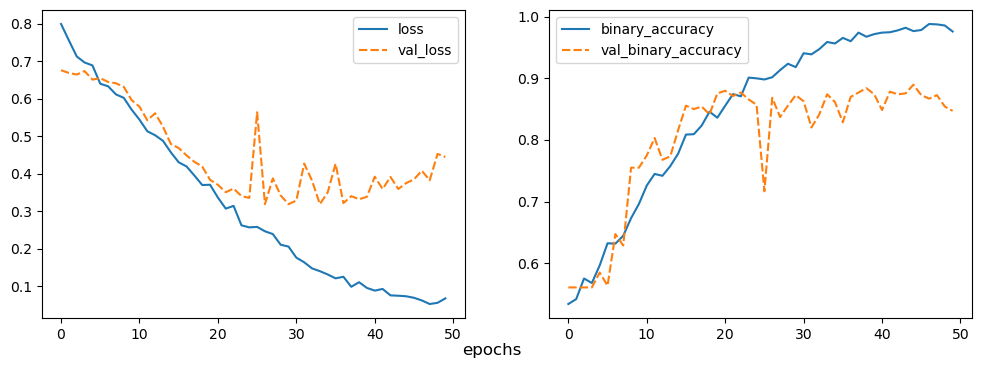

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(history_df[['loss', 'val_loss']], ax=ax1)
sns.lineplot(history_df[['binary_accuracy', 'val_binary_accuracy']], ax=ax2)
fig.supxlabel('epochs')

# Visualizations

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 25)      1900      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 110, 110, 25)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 25)        15650     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 12, 12, 25)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 25)         0         
 2D)                                                    

In [36]:
model.layers

In [37]:
model.layers[2].name

'max_pooling2d'

In [38]:
model.layers[1].get_config()

{'name': 'leaky_re_lu',
 'trainable': True,
 'dtype': 'float32',
 'alpha': 0.30000001192092896}

## filters

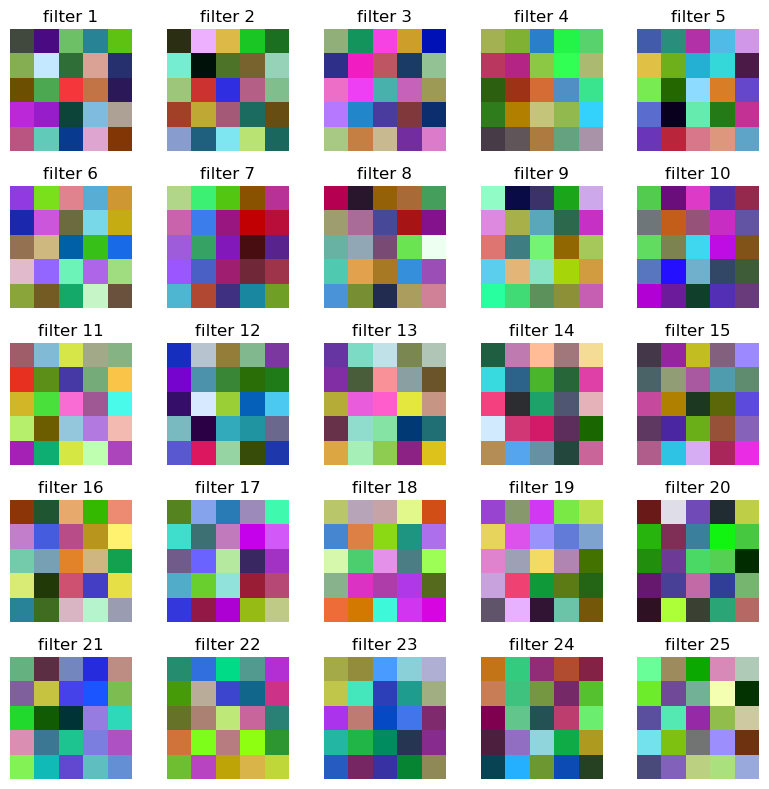

In [39]:
plt.figure(figsize=(8,8))
for i in range(25):
    layer_weights = model.get_layer(index=0).get_weights()[0][:,:,:,i]
    layer_weights -= layer_weights.min()
    layer_weights /= layer_weights.max()
    plt.subplot(5, 5, i+1)
    plt.imshow(layer_weights)
    plt.title('filter ' + str(i+1))
    plt.axis('off')
plt.tight_layout()

## intermediate layers

In [40]:
image = X_train[5]

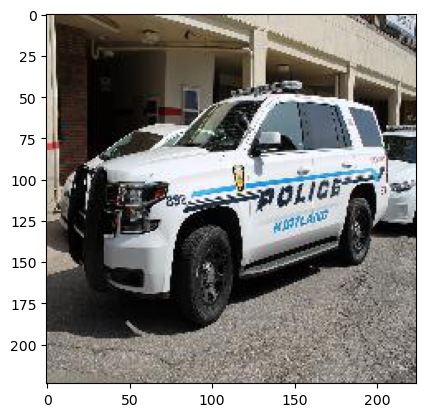

In [41]:
plt.imshow(X_train[5])

In [42]:
image.shape

(224, 224, 3)

In [43]:
image = image.reshape(1, image.shape[0], image.shape[1], image.shape[2])

In [44]:
image.shape

(1, 224, 224, 3)

In [45]:
[i.name for i in model.layers]

['conv2d',
 'leaky_re_lu',
 'max_pooling2d',
 'conv2d_1',
 'leaky_re_lu_1',
 'max_pooling2d_1',
 'flatten',
 'dense',
 'dropout',
 'batch_normalization',
 'dense_1',
 'dropout_1',
 'batch_normalization_1',
 'dense_2']

In [49]:
layer_names = [i.name for i in model.layers][:6]

In [50]:
outputs = []

In [51]:
for layer_name in layer_names:
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    outputs.append(intermediate_layer_model.predict(image))

1/1 [==============================] - 0s 46ms/step


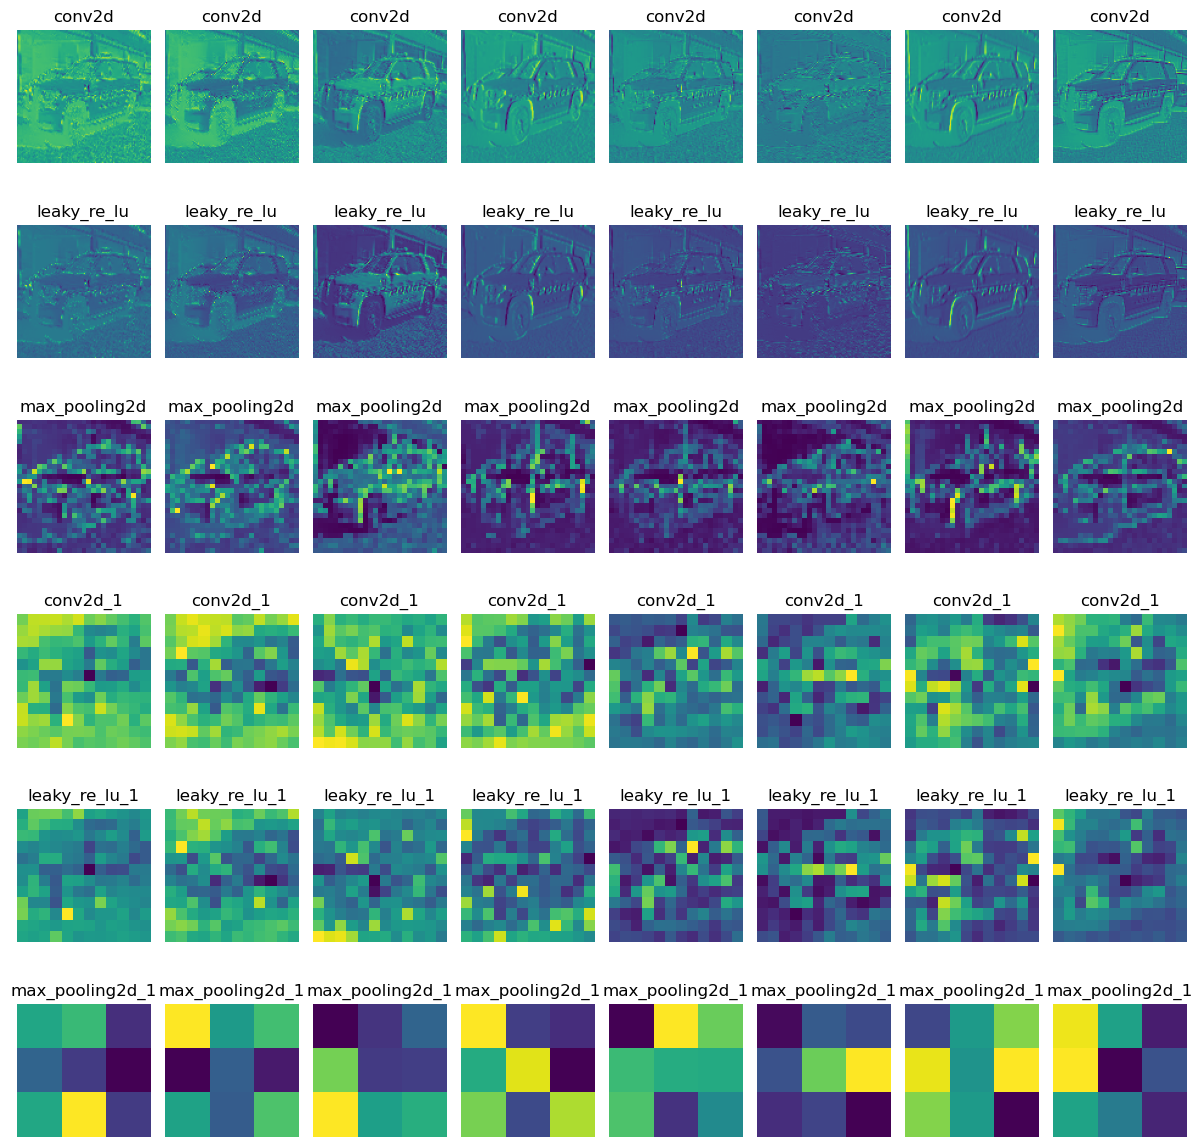

In [52]:
fig, axs = plt.subplots(6,8,figsize=(12,12))
for i in range(6):
    for z in range(8):
        axs[i][z].imshow(outputs[i][0,:,:,z])
        axs[i][z].set_title(layer_names[i])
        axs[i][z].axis('off')
plt.tight_layout()

## salience map

In [62]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, ExtractIntermediateLayer
from tf_keras_vis.utils.scores import CategoricalScore, BinaryScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress

In [55]:
from matplotlib import cm

In [56]:
saliency = Saliency(model, model_modifier=ReplaceToLinear(), clone=True)

In [57]:
saliency_map = saliency(BinaryScore(1.0), image, smooth_samples=20, smooth_noise=0.2)

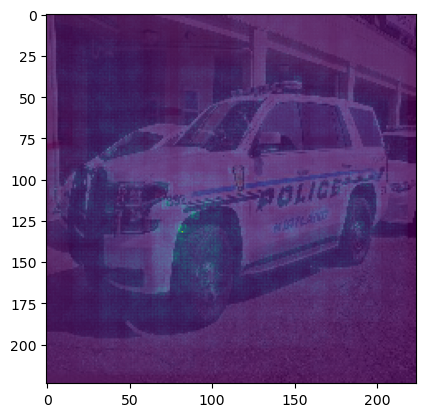

In [74]:
plt.imshow(X_train[5])
plt.imshow(saliency_map[0], alpha=0.8)

In [59]:
gradcam = Gradcam(model, model_modifier=ReplaceToLinear(), clone=True)

In [60]:
cam = gradcam(BinaryScore(1.0), image, penultimate_layer=-1)

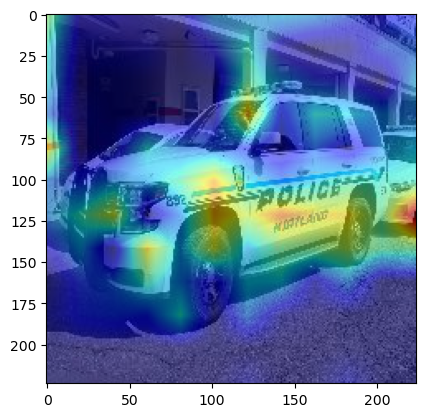

In [72]:
plt.imshow(X_train[5])
plt.imshow(np.uint8(cm.jet(cam[0])[..., :3] * 255), alpha=0.5)

In [63]:
gradcam_plusplus = GradcamPlusPlus(model, model_modifier=ReplaceToLinear(), clone=True)

In [64]:
cam_plusplus = gradcam_plusplus(BinaryScore(1.0), image, penultimate_layer=-1)

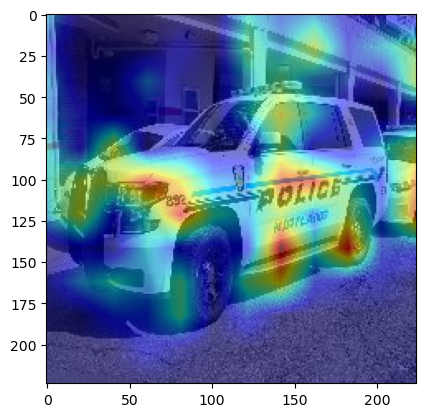

In [71]:
plt.imshow(X_train[5])
plt.imshow(np.uint8(cm.jet(cam_plusplus[0])[..., :3] * 255), alpha=0.5)

## activation maximization

In [76]:
model.layers[0].name

'conv2d'

In [77]:
extract_intermediate_layer = ExtractIntermediateLayer(index_or_name=model.layers[1].name)


In [78]:
activation_maximization = ActivationMaximization(model, 
                                            model_modifier=[extract_intermediate_layer, ReplaceToLinear()],
                                            clone=False)

In [79]:
activations = activation_maximization(CategoricalScore(0), callbacks=[Progress()])

200/200 [==============================] - 7s 37ms/step - Score: -7.9564 - TotalVariation2D: 4.5786 - Norm: 38.0285


In [80]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

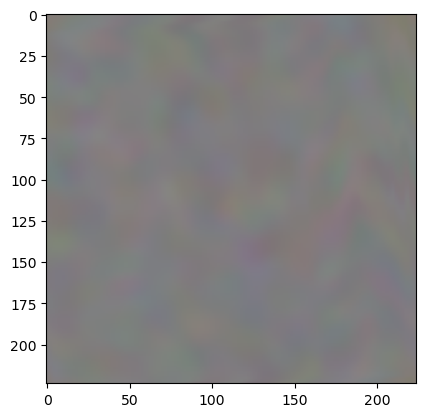

In [81]:
plt.imshow(activations[0].astype(np.uint8))

## occlusion map

In [82]:
def iter_occlusion(image, size=4):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
    (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
    ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
             x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
             = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
             tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]


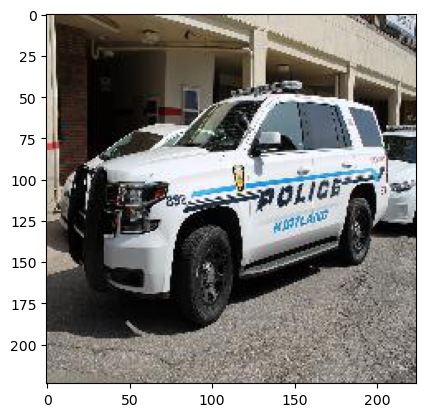

[None]

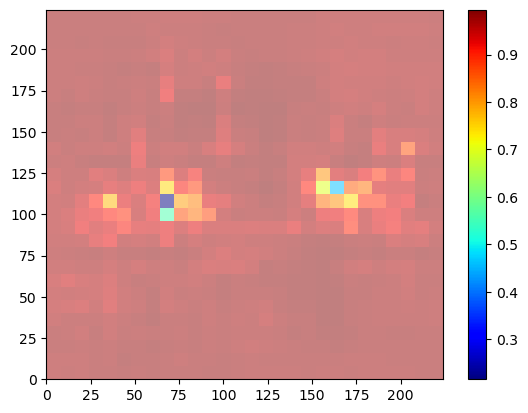

In [83]:

# take example image
image = X_train[5]
correct_class = np.argmax(y_train[5])

# define variables to use
img_size = image.shape[0]
occlusion_size = 8
heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(image, size=occlusion_size)):

    X = img_float.reshape(1, 224, 224, 3)
    out = model.predict(X, verbose=0)

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

plt.imshow(image)

plt.show()

plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.50)
plt.colorbar().solids.set(alpha=1)
